# 사고 - 위험운전 관계분석

## 1.위험운전횟수 집계 그래프

In [22]:
import pandas as pd

# 각 DTG 데이터프레임을 불러옵니다
dtg_dataframes = {}
for i in range(1, 13):
    dtg_var_name = f'Time_DTG_{i:02d}'
    dtg_dataframes[dtg_var_name] = pd.read_pickle(f'/home/jin_jb/DTG/DATA/{dtg_var_name}.pkl')

# 예시: DTG_01 데이터프레임에 접근
Time_DTG_01 = dtg_dataframes['Time_DTG_01']
Time_DTG_02 = dtg_dataframes['Time_DTG_02']
Time_DTG_03 = dtg_dataframes['Time_DTG_03']
Time_DTG_04 = dtg_dataframes['Time_DTG_04']
Time_DTG_05 = dtg_dataframes['Time_DTG_05']
Time_DTG_06 = dtg_dataframes['Time_DTG_06']
Time_DTG_07 = dtg_dataframes['Time_DTG_07']
Time_DTG_08 = dtg_dataframes['Time_DTG_08']
Time_DTG_09 = dtg_dataframes['Time_DTG_09']
Time_DTG_10 = dtg_dataframes['Time_DTG_10']
Time_DTG_11 = dtg_dataframes['Time_DTG_11']
Time_DTG_12 = dtg_dataframes['Time_DTG_12']


In [23]:
import pandas as pd

# Assuming the dataframes Time_DTG_01 to Time_DTG_12 are already loaded in the notebook
# Creating a list of these dataframes for ease of calculation
Time_DTG_dataframes = [Time_DTG_01, Time_DTG_02, Time_DTG_03, Time_DTG_04, Time_DTG_05, Time_DTG_06, Time_DTG_07, Time_DTG_08, Time_DTG_09, Time_DTG_10, Time_DTG_11, Time_DTG_12]

# Columns of interest
columns_of_interest = [
    "Speeding", "Long-term speeding", "Sudden acceleration", "Sudden start", "Sudden deceleration", "Sudden stop",
    "Sudden left turn", "Sudden right turn", "Sudden U-turn", "Sudden overtaking", "Sudden lane change"
]

# Function to calculate counts for a given dataframe
def calculate_counts(df):
    filtered_df = df[columns_of_interest]
    filtered_counts = filtered_df.sum()
    return pd.concat([pd.Series({"Speeding": filtered_counts["Speeding"]}), filtered_counts.drop("Speeding")])

# Calculate counts for each dataframe and sum them up
total_counts = pd.Series(dtype='int64')
for df in Time_DTG_dataframes:
    counts = calculate_counts(df)
    total_counts = total_counts.add(counts, fill_value=0)

# total_counts Series를 DataFrame으로 변환
total_counts_df = pd.DataFrame({'Category': total_counts.index, 'Count': total_counts.values})
total_counts_df

,Category,Count
0,Speeding,17254678.0
1,Long-term speeding,0.0
2,Sudden acceleration,45393506.0
3,Sudden start,92855.0
4,Sudden deceleration,18296282.0
5,Sudden stop,5638314.0
6,Sudden left turn,6411577.0
7,Sudden right turn,4213088.0
8,Sudden U-turn,972814.0
9,Sudden overtaking,2317787.0


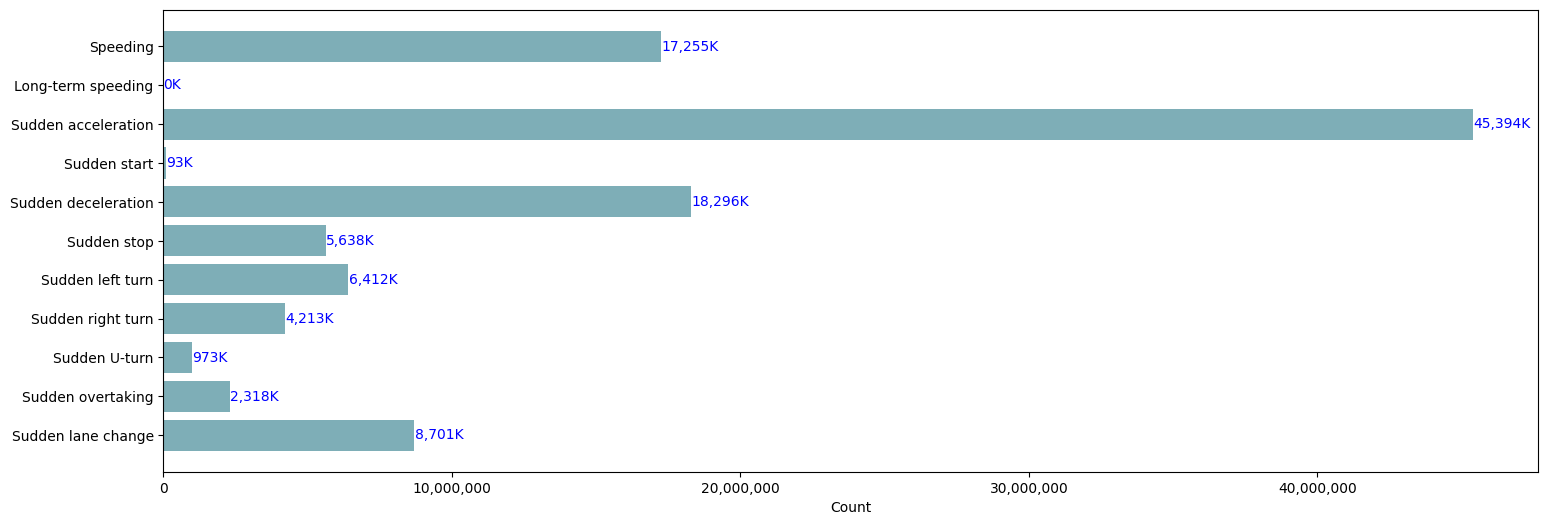

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plotting the data
plt.figure(figsize=(10, 6))
plt.barh(total_counts_df['Category'], total_counts_df['Count'], color='#7eaeb7')
plt.xlabel('Count')


bars = plt.barh(total_counts_df['Category'], total_counts_df['Count'], color='#7eaeb7')
# bars = plt.barh(total_counts_df['Category'], total_counts_df['Count'], color="#66b3ff")

# 막대에 레이블 추가 (천 단위 구분자 및 'k' 추가)
for bar in bars:
    width = bar.get_width()  # 막대의 너비 (실제 값)
    label_x_pos = width + 5000  # 레이블 위치를 막대 바깥으로 조금 올림
    label = f'{width/1000:,.0f}K'  # 천 단위 구분자와 'k' 추가
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, label, 
             va='center', ha='left', color='blue')

    
# x축 포맷 변경
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# 그래프의 여백 조정
plt.subplots_adjust(right=1.5)
plt.gca().invert_yaxis()  # Invert y-axis to display the highest value at the top
plt.show()

## 2. 사고에 따른 위험운전횟수 집계 그래프

### 대전 사고 데이터 불러오기(8,337개)

In [25]:
import pandas as pd

acc = pd.read_csv('/home/jin_jb/DTG/DATA/2019_TMC_T_W_ACC_INFO_GPS.csv')

acc['ACC_YMD'] = pd.to_datetime(acc['ACC_YMD'], format='%Y%m%d')

# 'ACC_YM'을 기준으로 데이터 정렬
acc = acc.sort_values(by='ACC_YMD')

# 정렬된 데이터의 처음 몇 줄 확인
acc = acc.reset_index(drop=True)

# DAY_CD 일요일: 1, 월요일: 2

acc = acc[['ACC_YMD','ACC_TME','DAY_CD','BJD_CD','ACC_PLC','ACC_GRD_CD','DEATH_CNT','SERI_CNT','SLTWD_CNT','WND_CNT','lon','lat']]

# ACC_TME를 문자열로 변환하고 HH:MM 형식으로 포맷팅
acc['ACC_TME_STR'] = acc['ACC_TME'].apply(lambda x: f"{str(x).zfill(4)[:2]}:{str(x).zfill(4)[2:]}")

# 시간만 추출하여 새로운 열 생성
acc['HOUR'] = acc['ACC_TME_STR'].str.split(':').str[0].astype(int)

# ACC_TME 열 제거
acc.drop('ACC_TME', axis=1, inplace=True)

# HOUR 열을 원하는 위치로 이동
# 여기서는 HOUR 열을 기존 ACC_TME 열이 있던 위치로 이동합니다.
hour_column = acc.pop('HOUR')
acc.insert(1, 'HOUR', hour_column)

acc.drop('ACC_TME_STR', axis=1, inplace=True)

daejeon_data = acc[acc['BJD_CD'].astype(str).str.startswith('30')]

# ACC_YMD와 HOUR 기준으로 정렬
dj_acc= daejeon_data.sort_values(by=['ACC_YMD', 'HOUR'])

# 인덱스 재설정
dj_acc.reset_index(drop=True, inplace=True)

# 'SERI_CNT', 'SLTWD_CNT', 'WND_CNT' 값을 합쳐서 'WND_CNT'에 저장
dj_acc['WND_CNT'] = dj_acc['SERI_CNT'] + dj_acc['SLTWD_CNT'] + dj_acc['WND_CNT']

# 'SERI_CNT'와 'SLTWD_CNT' 열을 제거
dj_acc.drop(['ACC_PLC','SERI_CNT', 'SLTWD_CNT'], axis=1, inplace=True)


dj_acc


/tmp/ipykernel_2818283/3136650761.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  acc = pd.read_csv('/home/jin_jb/DTG/DATA/2019_TMC_T_W_ACC_INFO_GPS.csv')


,ACC_YMD,HOUR,DAY_CD,BJD_CD,ACC_GRD_CD,DEATH_CNT,WND_CNT,lon,lat
0,2019-01-01,3,3,3.020013e+09,3,0,1,127.372955,36.407769
1,2019-01-01,12,3,3.011010e+09,2,0,1,127.454109,36.306999
2,2019-01-01,13,3,3.014010e+09,3,0,1,127.415028,36.333411
3,2019-01-01,13,3,3.020011e+09,3,0,1,127.332033,36.351625
4,2019-01-01,18,3,3.020014e+09,4,0,1,127.313203,36.391300
...,...,...,...,...,...,...,...,...,...
8332,2019-12-31,20,3,3.014011e+09,2,0,1,127.435187,36.316078
8333,2019-12-31,22,3,3.020011e+09,3,0,3,127.346471,36.348741
8334,2019-12-31,22,3,3.023012e+09,3,0,3,127.420927,36.427734
8335,2019-12-31,22,3,3.020014e+09,2,0,1,127.311831,36.396221


In [26]:
import geopandas as gpd

file_path = '/home/jin_jb/DTG/DATA/LSMD_ADM_SECT_UMD_대전/LSMD_ADM_SECT_UMD_30_202312.shp'

gdf = gpd.read_file(file_path, encoding = 'cp949')

gdf

,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry
0,30110101,30110,원동,1476,"POLYGON ((127.43429 36.32904, 127.43431 36.329..."
1,30110102,30110,인동,1477,"POLYGON ((127.43909 36.32427, 127.43898 36.324..."
2,30110103,30110,효동,1478,"POLYGON ((127.44155 36.31926, 127.44162 36.319..."
3,30110104,30110,천동,1479,"POLYGON ((127.44675 36.31952, 127.44680 36.319..."
4,30110105,30110,가오동,1480,"POLYGON ((127.45415 36.31216, 127.45425 36.312..."
...,...,...,...,...,...
172,30230122,30230,부수동,1648,"POLYGON ((127.47616 36.44571, 127.47677 36.445..."
173,30230123,30230,황호동,1649,"POLYGON ((127.50279 36.45550, 127.50280 36.455..."
174,30230124,30230,삼정동,1650,"POLYGON ((127.46258 36.45616, 127.46329 36.455..."
175,30230125,30230,미호동,1651,"POLYGON ((127.48423 36.47580, 127.48428 36.475..."


In [27]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


# 교통사고 데이터의 공간 데이터 포인트 생성
dj_acc['geometry'] = dj_acc.apply(
    lambda row: Point(row['lon'], row['lat']), axis=1)
traffic_accident_gdf = gpd.GeoDataFrame(dj_acc, geometry='geometry')

# 공간 조인 수행
acc_gdf = gpd.sjoin(traffic_accident_gdf, gdf, how='left', predicate='intersects')

# 'BJD_CD','lon','lat','geometry','index_right','SGG_OID' 열을 제거
acc_gdf.drop(['BJD_CD','lon','lat','geometry','index_right','SGG_OID'], axis=1, inplace=True)

# 조건에 맞는 행을 필터링하여 삭제
filtered_df = acc_gdf[~((acc_gdf.index.isin([1373, 4037])) & (acc_gdf['EMD_NM'] == '원내동'))]
acc_gdf = filtered_df
acc_gdf

/tmp/ipykernel_2818283/1775279197.py:12: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...

  acc_gdf = gpd.sjoin(traffic_accident_gdf, gdf, how='left', predicate='intersects')


,ACC_YMD,HOUR,DAY_CD,ACC_GRD_CD,DEATH_CNT,WND_CNT,EMD_CD,COL_ADM_SE,EMD_NM
0,2019-01-01,3,3,3,0,1,30200129,30200,방현동
1,2019-01-01,12,3,2,0,1,30110105,30110,가오동
2,2019-01-01,13,3,3,0,1,30140103,30140,목동
3,2019-01-01,13,3,3,0,1,30200112,30200,구암동
4,2019-01-01,18,3,4,0,1,30200139,30200,반석동
...,...,...,...,...,...,...,...,...,...
8332,2019-12-31,20,3,2,0,1,30140111,30140,부사동
8333,2019-12-31,22,3,3,0,3,30200111,30200,봉명동
8334,2019-12-31,22,3,3,0,3,30230116,30230,상서동
8335,2019-12-31,22,3,2,0,1,30200139,30200,반석동


In [28]:
import pandas as pd
import gc

# 각 DTG 데이터프레임을 불러옵니다
dtg_dataframes = {}
for i in range(1, 13):
    dtg_var_name = f'GEO_DTG_{i:02d}'
    dtg_dataframes[dtg_var_name] = pd.read_pickle(f'/home/jin_jb/DTG/DATA/{dtg_var_name}.pkl')

# 예시: DTG_01 데이터프레임에 접근
GEO_DTG_01 = dtg_dataframes['GEO_DTG_01']
GEO_DTG_02 = dtg_dataframes['GEO_DTG_02']
GEO_DTG_03 = dtg_dataframes['GEO_DTG_03']
GEO_DTG_04 = dtg_dataframes['GEO_DTG_04']
GEO_DTG_05 = dtg_dataframes['GEO_DTG_05']
GEO_DTG_06 = dtg_dataframes['GEO_DTG_06']
GEO_DTG_07 = dtg_dataframes['GEO_DTG_07']
GEO_DTG_08 = dtg_dataframes['GEO_DTG_08']
GEO_DTG_09 = dtg_dataframes['GEO_DTG_09']
GEO_DTG_10 = dtg_dataframes['GEO_DTG_10']
GEO_DTG_11 = dtg_dataframes['GEO_DTG_11']
GEO_DTG_12 = dtg_dataframes['GEO_DTG_12']

In [29]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
GEO_DTG = pd.read_pickle("/home/jin_jb/DTG/DATA/GEO_DTG.pkl")
accidents_gdf = gpd.GeoDataFrame(GEO_DTG, geometry=gpd.points_from_xy(GEO_DTG.lon, GEO_DTG.lat))
accidents_gdf = accidents_gdf.drop(['TRANSCO_CD','CAR_REG_NO','TRIP_ID','OPT_SPD','DAY_CD'], axis = 1)
accidents_gdf

,OPT_DT,HOUR,Speeding,Long-term speeding,Sudden acceleration,Sudden start,Sudden deceleration,Sudden stop,Sudden left turn,Sudden right turn,...,Sudden overtaking,Sudden lane change,EMD_CD,EMD_NM,ACC_GRD_CD,DEATH_CNT,WND_CNT,lon,lat,geometry
0,2019-01-01,19,0,0,1,0,0,0,0,0,...,0,0,30170112,둔산동,1,1,0,127.379560,36.355946,POINT (127.37956 36.35595)
1,2019-01-01,19,1,0,0,0,0,0,0,0,...,0,0,30170112,둔산동,1,1,0,127.379560,36.355946,POINT (127.37956 36.35595)
2,2019-01-01,18,0,0,0,0,0,0,0,0,...,0,0,30170112,둔산동,3,0,2,127.379281,36.355766,POINT (127.37928 36.35577)
3,2019-01-01,18,0,0,0,0,0,0,0,0,...,0,0,30170112,둔산동,3,0,2,127.379281,36.355766,POINT (127.37928 36.35577)
4,2019-01-01,19,0,0,0,0,0,0,0,0,...,0,0,30170112,둔산동,1,1,0,127.379560,36.355946,POINT (127.37956 36.35595)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863692,2019-12-31,11,0,0,0,0,0,0,0,0,...,0,0,30200130,화암동,3,0,1,127.377793,36.416744,POINT (127.37779 36.41674)
1863693,2019-12-31,11,1,0,0,0,0,0,0,0,...,0,0,30200130,화암동,3,0,1,127.377793,36.416744,POINT (127.37779 36.41674)
1863694,2019-12-31,10,0,0,1,0,0,0,0,0,...,0,0,30170116,관저동,2,0,2,127.334089,36.301538,POINT (127.33409 36.30154)
1863695,2019-12-31,10,0,0,1,0,0,0,0,0,...,0,0,30170116,관저동,2,0,2,127.334089,36.301538,POINT (127.33409 36.30154)


In [30]:
# ACC_GRD_CD로 그룹화하고 DEATH_CNT와 WND_CNT의 합계를 계산
ACC_GRD_DTG = GEO_DTG[['Speeding', 'Long-term speeding','Sudden acceleration','Sudden start','Sudden deceleration','Sudden stop',
                                              'Sudden left turn','Sudden right turn','Sudden U-turn','Sudden overtaking','Sudden lane change']].sum().reset_index()
# ACC_GRD_DTG_cnt['Total_Sum'] = ACC_GRD_DTG_cnt[['Speeding', 'Long-term speeding','Sudden acceleration','Sudden start','Sudden deceleration','Sudden stop',
#                                               'Sudden left turn','Sudden right turn','Sudden U-turn','Sudden overtaking','Sudden lane change']].sum(axis = 1)
# 열 이름 변경
ACC_GRD_DTG = ACC_GRD_DTG.rename(columns={'index': 'Category', 0: 'Count'})
ACC_GRD_DTG

,Category,Count
0,Speeding,137333
1,Long-term speeding,0
2,Sudden acceleration,818678
3,Sudden start,1745
4,Sudden deceleration,280468
5,Sudden stop,95428
6,Sudden left turn,91687
7,Sudden right turn,52144
8,Sudden U-turn,11679
9,Sudden overtaking,38853


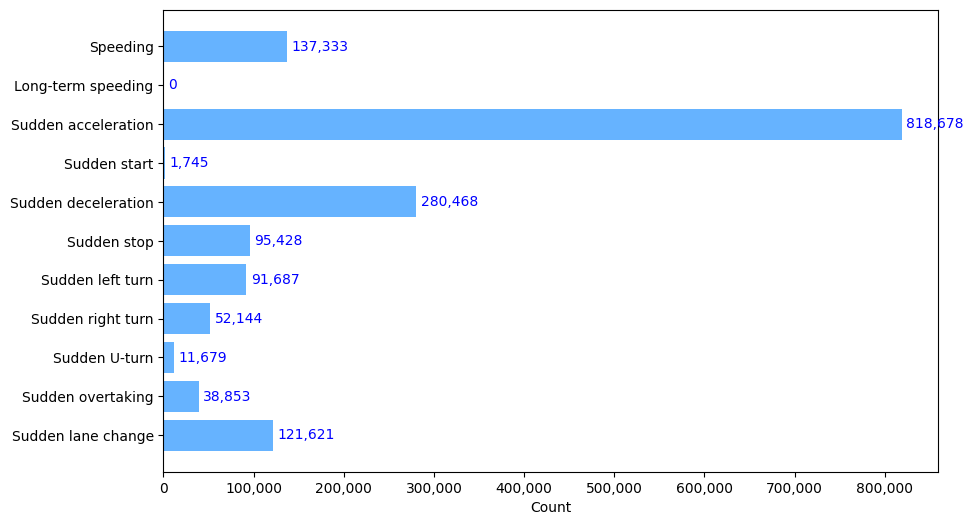

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plotting the data
plt.figure(figsize=(10, 6))
plt.barh(ACC_GRD_DTG['Category'], ACC_GRD_DTG['Count'], color='#9edae5')
plt.xlabel('Count')


# bars = plt.barh(ACC_GRD_DTG['Category'], ACC_GRD_DTG['Count'], color='#9edae5')
bars = plt.barh(ACC_GRD_DTG['Category'], ACC_GRD_DTG['Count'], color = "#66b3ff")

# 막대에 레이블 추가 (천 단위 구분자 및 'k' 추가)
for bar in bars:
    width = bar.get_width()  # 막대의 너비 (실제 값)
    label_x_pos = width + 5000  # 레이블 위치를 막대 바깥으로 조금 올림
    # label = f'{width/1000:,.0f}k'  # 천 단위 구분자와 'k' 추가
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2,
            #  label, 
             f'{width:,.0f}',
             va='center', ha='left', color='blue')
    
# x축 포맷 변경
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().invert_yaxis()  # Invert y-axis to display the highest value at the top
plt.show()

## 3. 사고 등급에 따른 그래프의 유형
#### 1사망사고, 2중상사고, 3경상사고, 4부상사고

In [32]:
# ACC_GRD_CD로 그룹화하고 DEATH_CNT와 WND_CNT의 합계를 계산
ACC_GRD_DTG_cnt = GEO_DTG.groupby('ACC_GRD_CD')[['Speeding', 'Long-term speeding','Sudden acceleration','Sudden start','Sudden deceleration','Sudden stop',
                                              'Sudden left turn','Sudden right turn','Sudden U-turn','Sudden overtaking','Sudden lane change']].sum().reset_index()
# ACC_GRD_DTG_cnt['Total_Sum'] = ACC_GRD_DTG_cnt[['Speeding', 'Long-term speeding','Sudden acceleration','Sudden start','Sudden deceleration','Sudden stop',
#                                               'Sudden left turn','Sudden right turn','Sudden U-turn','Sudden overtaking','Sudden lane change']].sum(axis = 1)
ACC_GRD_DTG_cnt

,ACC_GRD_CD,Speeding,Long-term speeding,Sudden acceleration,Sudden start,Sudden deceleration,Sudden stop,Sudden left turn,Sudden right turn,Sudden U-turn,Sudden overtaking,Sudden lane change
0,1,1439,0,6205,16,2080,742,607,385,72,278,881
1,2,28607,0,168442,323,57834,19470,18798,10637,2339,8144,25357
2,3,103736,0,624694,1377,213505,72795,70127,39751,8984,29542,92412
3,4,3551,0,19337,29,7049,2421,2155,1371,284,889,2971


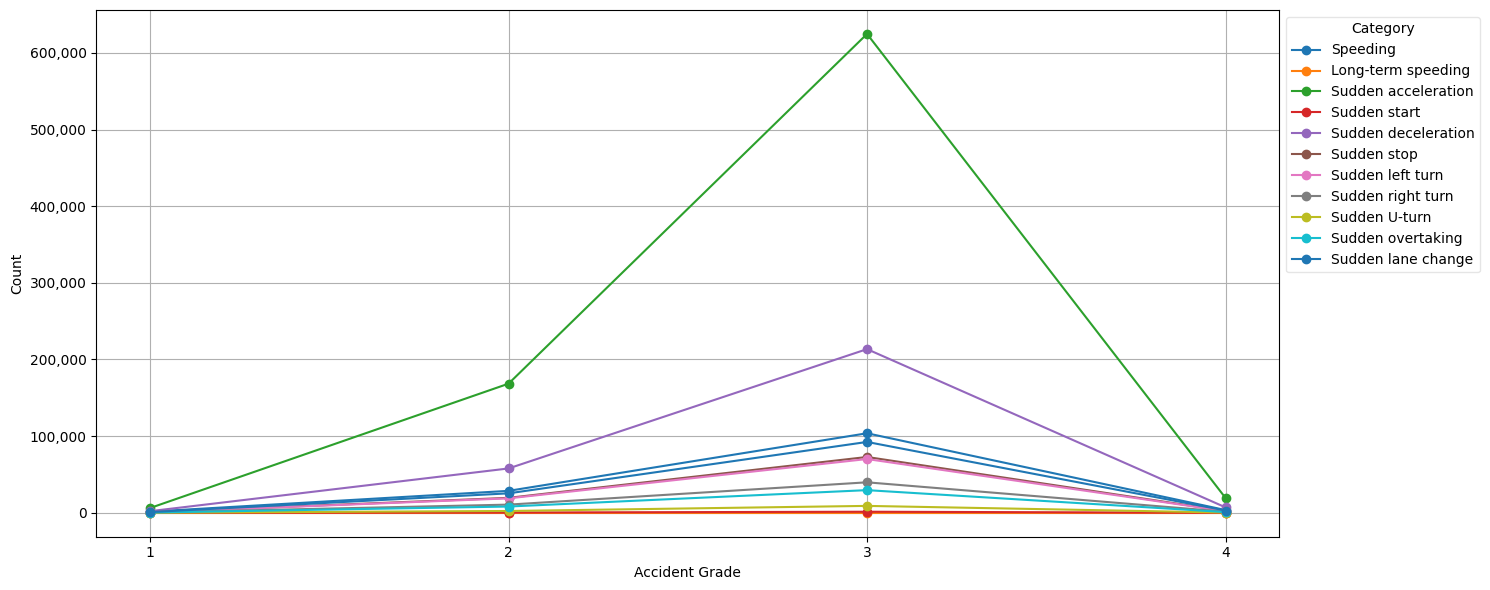

In [33]:
# 필요한 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

melted_data = ACC_GRD_DTG_cnt.melt(id_vars='ACC_GRD_CD', var_name='Category', value_name='Count')

# 그래프 그리기
plt.figure(figsize=(15, 6))

# 사고 등급별로 각 카테고리의 카운트를 그래프에 표시
for category in melted_data['Category'].unique():
    category_data = melted_data[melted_data['Category'] == category]
    plt.plot(category_data['ACC_GRD_CD'], category_data['Count'], marker='o', label=category)

plt.xticks(ticks=ACC_GRD_DTG_cnt['ACC_GRD_CD'], labels=ACC_GRD_DTG_cnt['ACC_GRD_CD'], rotation=0)
plt.xlabel('Accident Grade')
plt.ylabel('Count')
# plt.title('Count of Each Accident Grade by Category')

# y축 레이블 형식 변경
plt.gca().ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# 레전드 설정
plt.legend(loc='upper left', bbox_to_anchor=(1,1), title='Category', framealpha=0.5)

plt.tight_layout()
plt.grid(True)
plt.show()

In [34]:
acc_grd_counts = pd.DataFrame(dj_acc['ACC_GRD_CD'].value_counts()).reset_index()
acc_grd_counts
# ACC_GRD_CD로 그룹화하고 DEATH_CNT와 WND_CNT의 합계를 계산
grouped_data = dj_acc.groupby('ACC_GRD_CD')[['DEATH_CNT', 'WND_CNT']].sum().reset_index()
grouped_data

# 두 DataFrame을 ACC_GRD_CD를 기준으로 합치기
combined_data = pd.merge(grouped_data, acc_grd_counts, on='ACC_GRD_CD', how='left')

combined_data.rename(columns={'ACC_GRD_CD': 'Accident Grade', 'count': 'Frequency', 
                                       'DEATH_CNT': 'Death Count', 'WND_CNT': 'Wound Count'}, inplace=True)

# 열 순서를 재정의합니다.
new_order = ['Accident Grade', 'Frequency', 'Death Count', 'Wound Count']

# 열 순서를 바탕으로 데이터프레임을 재구성합니다.
combined_data = combined_data[new_order]

accident_frequency = combined_data.drop(['Death Count','Wound Count'],axis = 1)
accident_frequency



,Accident Grade,Frequency
0,1,74
1,2,1782
2,3,6258
3,4,223


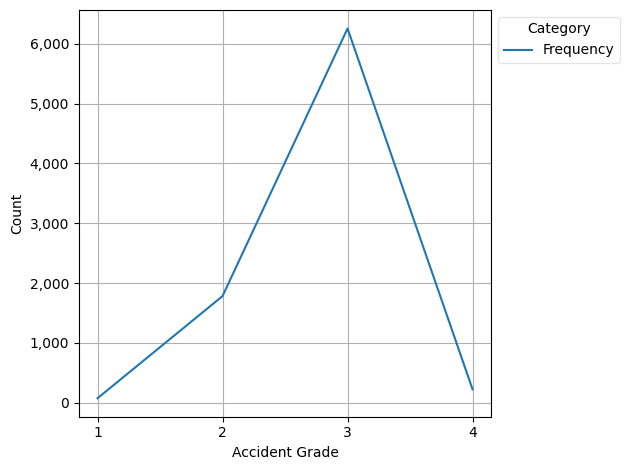

In [35]:
plt.plot(combined_data['Accident Grade'], combined_data['Frequency'], label='Frequency')

plt.xticks(ticks=combined_data['Accident Grade'], labels=combined_data['Accident Grade'], rotation=0)
plt.xlabel('Accident Grade')
plt.ylabel('Count')
# plt.title('Count of Each Accident Grade by Category')

# y축 레이블 형식 변경
plt.gca().ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# 레전드 설정
plt.legend(loc='upper left', bbox_to_anchor=(1,1), title='Category', framealpha=0.5)

plt.tight_layout()
plt.grid(True)
plt.show()

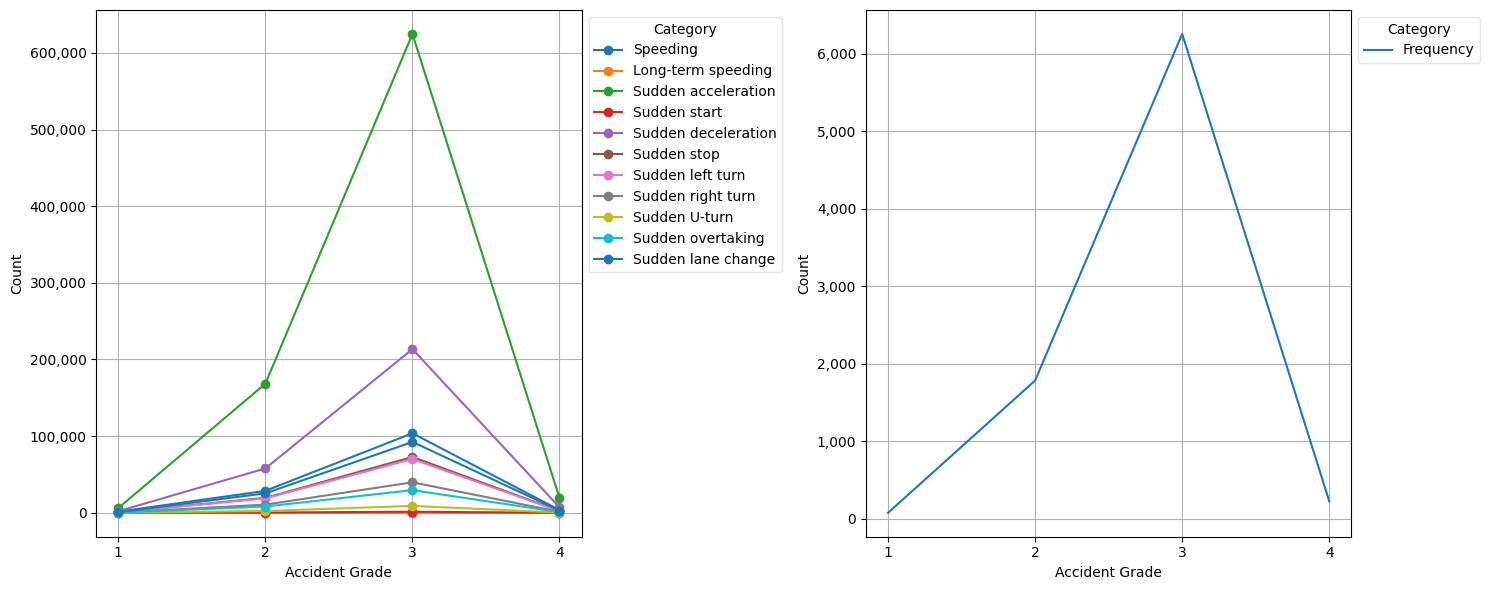

In [36]:
# 그래프 그리기
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
# 사고 등급별로 각 카테고리의 카운트를 그래프에 표시
for category in melted_data['Category'].unique():
    category_data = melted_data[melted_data['Category'] == category]
    plt.plot(category_data['ACC_GRD_CD'], category_data['Count'], marker='o', label=category)

plt.xticks(ticks=ACC_GRD_DTG_cnt['ACC_GRD_CD'], labels=ACC_GRD_DTG_cnt['ACC_GRD_CD'], rotation=0)
plt.xlabel('Accident Grade')
plt.ylabel('Count')
# plt.title('Count of Each Accident Grade by Category')

# y축 레이블 형식 변경
plt.gca().ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# 레전드 설정
plt.legend(loc='upper left', bbox_to_anchor=(1,1), title='Category', framealpha=0.5)

plt.tight_layout()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(combined_data['Accident Grade'], combined_data['Frequency'], label='Frequency')

plt.xticks(ticks=combined_data['Accident Grade'], labels=combined_data['Accident Grade'], rotation=0)
plt.xlabel('Accident Grade')
plt.ylabel('Count')
# plt.title('Count of Each Accident Grade by Category')

# y축 레이블 형식 변경
plt.gca().ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# 레전드 설정
plt.legend(loc='upper left', bbox_to_anchor=(1,1), title='Category', framealpha=0.5)
# plt.suptitle('2019 Accident - Risky Driving Behavior Relationship')
plt.tight_layout()
plt.grid(True)
plt.show()